In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn as sk
import contextlib
% pylab inline

#for python2, uncomment the below line:
#from __future__ import print_function

Populating the interactive namespace from numpy and matplotlib


In [2]:
#http://stackoverflow.com/questions/2891790/pretty-printing-of-numpy-array
#set a function to manage the print options of specific arrays
@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

**Import Data, Check Healthiness, Verify Can Drop NAs**

(this is a preliminary run through, using only NY County, All Industry Sectors, quarterly data from 2000 - 2014)

In [3]:
#reading in QWI indicators for the 4 counties in NYC (New York, Kings)

df = pd.read_csv('~/Documents/GRA/QWI_indicators/qwi_5c2543d712bc416f82683ab99e1517f6.csv')

In [4]:
#print out a list of columns
df.columns

Index(['periodicity', 'periodicity_label.value', 'seasonadj',
       'seasonadj_label.value', 'geo_level', 'geo_level_label.value',
       'geography', 'geography_label.value', 'ind_level',
       'ind_level_label.value', 'industry', 'industry_label.value',
       'ownercode', 'ownercode_label.value', 'sex', 'sex_label.value',
       'agegrp', 'agegrp_label.value', 'race', 'race_label.value', 'ethnicity',
       'ethnicity_label.value', 'education', 'education_label.value',
       'firmage', 'firmage_label.value', 'firmsize', 'firmsize_label.value',
       'year', 'quarter', 'Emp', 'EmpEnd', 'EmpS', 'EmpSpv', 'EmpTotal',
       'HirA', 'HirN', 'HirR', 'Sep', 'HirAEnd', 'HirAEndR', 'SepBeg',
       'SepBegR', 'HirAS', 'HirNS', 'SepS', 'SepSnx', 'TurnOvrS', 'FrmJbGn',
       'FrmJbLs', 'FrmJbC', 'HirAEndRepl', 'HirAEndReplR', 'FrmJbGnS',
       'FrmJbLsS', 'FrmJbCS', 'EarnS', 'EarnBeg', 'EarnHirAS', 'EarnHirNS',
       'EarnSepS', 'Payroll', 'sEmp', 'sEmpEnd', 'sEmpS', 'sEmpSpv',
       

In [5]:
#remove the flags, which have a lowercase s followed by a capitalized column name
columns_no_flags = [word for word in df.columns if not word[1].isupper()]

#subset to new DF with no flags
df = df[columns_no_flags]
df.columns = [x.replace('.','_') for x in df.columns]

In [6]:
def print_full(x):
    #this function takes in a dataframe and prints the head of the df with all columns displayed
    #it then resets back to the default column display afterwards
    pd.set_option('display.max_columns', 500)
    print(x.head(10))
    pd.reset_option('display.max_columns')
    
print_full(df)
#df.dtypes

  periodicity periodicity_label_value seasonadj    seasonadj_label_value  \
0           Q          Quarterly data         U  Not seasonally adjusted   
1           Q          Quarterly data         U  Not seasonally adjusted   
2           Q          Quarterly data         U  Not seasonally adjusted   
3           Q          Quarterly data         U  Not seasonally adjusted   
4           Q          Quarterly data         U  Not seasonally adjusted   
5           Q          Quarterly data         U  Not seasonally adjusted   
6           Q          Quarterly data         U  Not seasonally adjusted   
7           Q          Quarterly data         U  Not seasonally adjusted   
8           Q          Quarterly data         U  Not seasonally adjusted   
9           Q          Quarterly data         U  Not seasonally adjusted   

  geo_level geo_level_label_value  geography geography_label_value ind_level  \
0         S                States         36              New York         A   
1  

In [7]:
#create new column 'period' that maps the 
df['period'] = df.year.map(str) + "_" + df.quarter.map(str)


In [8]:
#want data for Manhattan (county = 'New York, NY')
df_ny = df[df.geography_label_value == 'New York, NY']
#only using data from all industries in this example
mask = (df_ny.industry == '00')
df_ny_all = df_ny[mask]
#set the period as the index, so we can keep it when we go to all numerics
df_ny_all = df_ny_all.set_index(df_ny_all.period)


In [9]:
#select numeric columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data = df_ny_all.select_dtypes(include=numerics)

#move period back from index
data.reset_index(level=0, inplace=True)



In [10]:
#drop geography, sex, firmage, firmsize
data.drop(['geography', 'sex', 'firmage', 'firmsize'], axis=1, inplace=True)

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


period          0
year            0
quarter         0
Emp             1
EmpEnd          1
EmpS            2
EmpSpv          2
EmpTotal        0
HirA            1
HirN            4
HirR            4
Sep             1
HirAEnd         2
HirAEndR        2
SepBeg          2
SepBegR         2
HirAS           3
HirNS           6
SepS            3
SepSnx          3
TurnOvrS        4
FrmJbGn         2
FrmJbLs         2
FrmJbC          2
HirAEndRepl     2
HirAEndReplR    2
FrmJbGnS        3
FrmJbLsS        3
FrmJbCS         3
EarnS           2
EarnBeg         1
EarnHirAS       3
EarnHirNS       6
EarnSepS        3
Payroll         0
dtype: int64


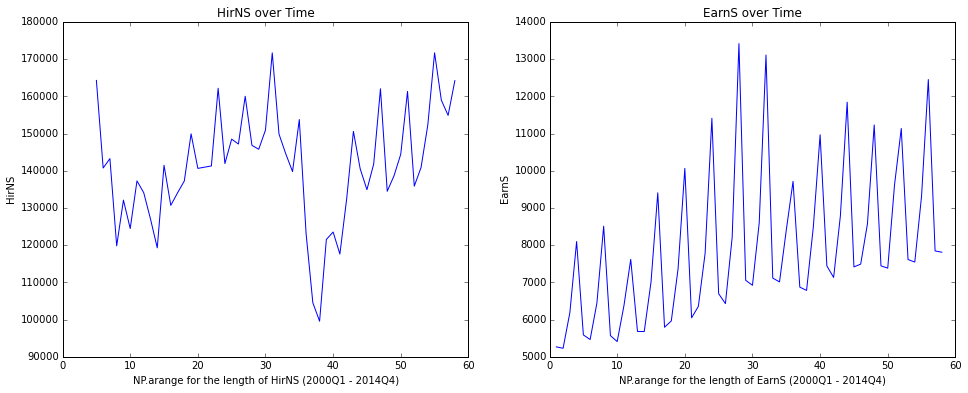

In [11]:
#check number of NaNs before Drop the values
print(data.isnull().sum())

#before drop the NANs, verify position
#from printout, can see there are 6 in HirNS, 2 in EarnS

#points_ax1 = np.arange(len(data.HirNS))

fig, ((ax1, ax2)) = plt.subplots(figsize=(16,6), nrows=1, ncols=2)
ax1.plot(np.arange(len(data.HirNS)), data.HirNS, label = 'all data')
ax1.set_xlabel('NP.arange for the length of HirNS (2000Q1 - 2014Q4)')
ax1.set_ylabel('HirNS')
ax1.set_title('HirNS over Time')

ax2.plot(np.arange(len(data.EarnS)), data.EarnS, label = 'all data')
ax2.set_xlabel('NP.arange for the length of EarnS (2000Q1 - 2014Q4)')
ax2.set_ylabel('EarnS')
ax2.set_title('EarnS over Time')


#based off the graph below, these are in early 2000 and then again in late 2014. Can now drop them
data = data.dropna()

**SIDENOTE: will have to detrend Q4 earnings, but checking the outputs of scipy detrend vs original**

- Need to just detrend Q4 of each year, have to write custom function for this

References for Detrending:

http://www.ltrr.arizona.edu/~dmeko/notes_7.pdf

ftp://ftp.repec.org/opt/ReDIF/RePEc/usu/pdf/ERI2002-05.pdf

http://www.swharden.com/blog/2010-06-24-detrending-data-in-python-with-numpy/



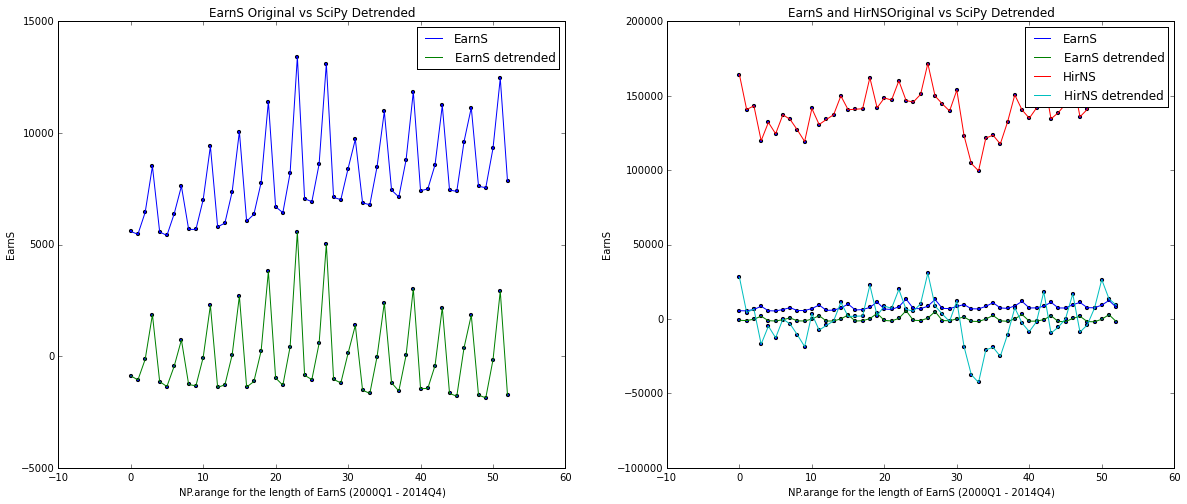

In [19]:
import scipy.signal
test=scipy.signal.detrend(data.EarnS)
testH=scipy.signal.detrend(data.HirNS)

fig, ((ax1, ax2)) = plt.subplots(figsize=(20,8), nrows=1, ncols=2)

ax1.plot(np.arange(len(data.EarnS)), data.EarnS, label = 'EarnS')
ax1.plot(np.arange(len(test)), test, label = 'EarnS detrended')
ax1.scatter(np.arange(len(data.EarnS)), data.EarnS, s=10)
ax1.scatter(np.arange(len(test)), test, s=10)

ax1.set_xlabel('NP.arange for the length of EarnS (2000Q1 - 2014Q4)')
ax1.set_ylabel('EarnS')
ax1.set_title('EarnS Original vs SciPy Detrended')
ax1.legend()


#Putting the HirNS on the same scale to check the Q4 spikes

ax2.plot(np.arange(len(data.EarnS)), data.EarnS, label = 'EarnS')
ax2.plot(np.arange(len(test)), test, label = 'EarnS detrended')
ax2.scatter(np.arange(len(data.EarnS)), data.EarnS, s=10)
ax2.scatter(np.arange(len(test)), test, s=10)

ax2.plot(np.arange(len(data.HirNS)), data.HirNS, label = 'HirNS')
ax2.plot(np.arange(len(testH)), testH, label = 'HirNS detrended')
ax2.scatter(np.arange(len(data.HirNS)), data.HirNS, s=10)
ax2.scatter(np.arange(len(testH)), testH, s=10)


ax2.set_xlabel('NP.arange for the length of EarnS (2000Q1 - 2014Q4)')
ax2.set_ylabel('EarnS')
ax2.set_title('EarnS and HirNSOriginal vs SciPy Detrended')
ax2.legend()



**Principle Component Analysis, v1**

(using all columns -- doing with sklearn)

In [14]:
#convert dataframe to a numpy array
skdata= data.as_matrix()
print(skdata.shape)

#drop the first three columns: period, year, quarter -- all that remains are the numeric indicator columns
skdata = skdata[:,3:]
print(skdata.shape)

(53, 35)
(53, 32)


In [15]:
#normalize the features (axis = 0) so be on the same scale before PCA

from sklearn.preprocessing import normalize
from sklearn import decomposition

#normalize the data
skdata_norm = sk.preprocessing.normalize(skdata, norm='l2', axis=0, copy=True)

#PCA with features normalized
pca = decomposition.PCA(n_components = 'mle')
pca.fit(skdata_norm)

#printout of the variance explained by each column
with printoptions(precision=3, suppress=True):
    print('PCA WITH FEATURES NORMALIZED:\n', pca.explained_variance_ratio_) 
#X = pca.transform(skdata_norm)


PCA WITH FEATURES NORMALIZED:
 [ 0.631  0.18   0.086  0.043  0.022  0.018  0.012  0.003  0.002  0.001
  0.001  0.001  0.001  0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
